<a href="https://colab.research.google.com/github/Nishlesh/Monte-carlo/blob/main/Bull_Spread_strategy_optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    Strike_1  Strike_2  Max_Profit  Max_Loss  Reward_Risk_Ratio  \
0    24300.0   24350.0      550.00    700.00           0.785714   
1    24300.0   24400.0     1025.00   1475.00           0.694915   
2    24300.0   24450.0     1840.00   1910.00           0.963351   
3    24300.0   24500.0     2400.00   2600.00           0.923077   
4    24250.0   24350.0      988.75   1511.25           0.654260   
5    24250.0   24400.0     1463.75   2286.25           0.640241   
6    24250.0   24450.0     2278.75   2721.25           0.837391   
7    24250.0   24500.0     2838.75   3411.25           0.832173   
8    24350.0   24400.0      475.00    775.00           0.612903   
9    24350.0   24450.0     1290.00   1210.00           1.066116   
10   24350.0   24500.0     1850.00   1900.00           0.973684   
11   24200.0   24400.0     1925.00   3075.00           0.626016   
12   24200.0   24450.0     2740.00   3510.00           0.780627   
13   24200.0   24500.0     3300.00   4200.00           0.78571

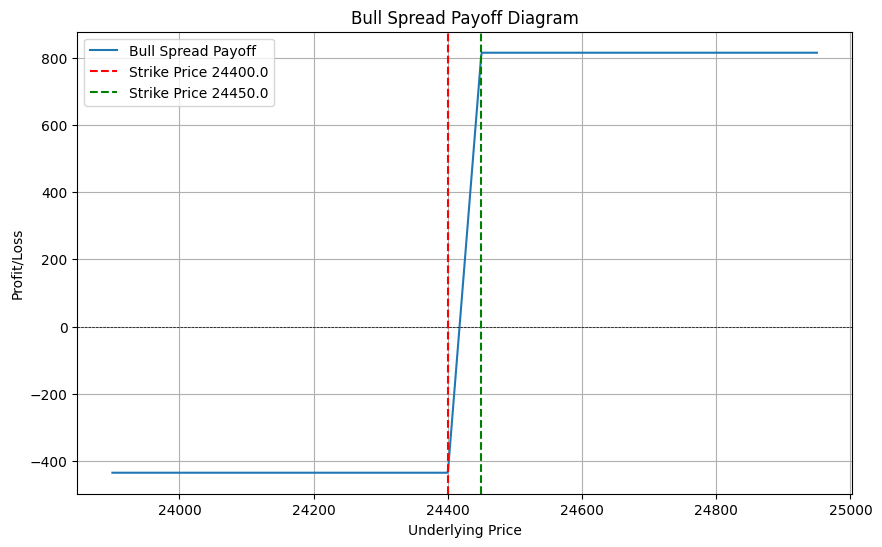

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools

# Load the data
file_path = '/content/option-chain-ED-NIFTY-25-Jul-2024.csv'
df = pd.read_csv(file_path)

# Extract relevant columns
df = df[['STRIKE', 'IV_CALLS', 'LTP_CALLS']]
df['STRIKE'] = df['STRIKE'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS'].replace('-', np.nan).astype(float)
df['LTP_CALLS'] = df['LTP_CALLS'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS']/100
# Define constants
S0 = 24324  # Current price of NIFTY
T = 20 / 365  # Time to expiry
r = 0.10  # Risk-free rate
lot_size = 25  # Lot size

# Generate nearest 10 strike prices to the ATM
ATM_strike = df.iloc[(df['STRIKE'] - S0).abs().argsort()[:1]]['STRIKE'].values[0]
strike_prices = df['STRIKE'].unique()
nearest_strikes = sorted(strike_prices, key=lambda x: abs(x - ATM_strike))[:10]

# Filter relevant rows for nearest strikes and use LTP_CALLS directly
df_nearest = df[df['STRIKE'].isin(nearest_strikes)].copy()
df_nearest['Call_Price'] = df_nearest['LTP_CALLS']

# Generate all possible bull spread combinations
bull_spreads = list(itertools.combinations(nearest_strikes, 2))
strategies = []

for (K1, K2) in bull_spreads:
    if K1 < K2:
        call_price_1 = df_nearest[df_nearest['STRIKE'] == K1]['Call_Price'].values[0]
        call_price_2 = df_nearest[df_nearest['STRIKE'] == K2]['Call_Price'].values[0]

        # Calculate max profit, max loss, reward/risk ratio, and probability of profit
        max_profit = (K2 - K1) - (call_price_1 - call_price_2)
        max_loss = call_price_1 - call_price_2
        reward_risk_ratio = max_profit / max_loss

        # Assuming probability of profit based on ATM strike and distance between strikes
        prob_profit = norm.cdf((np.log(S0 / K1) + (r - 0.5 * ((df_nearest[df_nearest['STRIKE'] == K1]['IV_CALLS'].values[0]+df_nearest[df_nearest['STRIKE'] == K2]['IV_CALLS'].values[0])/2) ** 2) * T) / ((df_nearest[df_nearest['STRIKE'] == K1]['IV_CALLS'].values[0]+df_nearest[df_nearest['STRIKE'] == K1]['IV_CALLS'].values[0]) * np.sqrt(T)/2))

        strategies.append({
            'Strike_1': K1,
            'Strike_2': K2,
            'Max_Profit': max_profit * lot_size,
            'Max_Loss': max_loss * lot_size,
            'Reward_Risk_Ratio': reward_risk_ratio,
            'Probability_of_Profit': prob_profit
        })

# Create DataFrame from strategies list
strategies_df = pd.DataFrame(strategies)
print(strategies_df)
# TOPSIS method
def topsis(df, weights):
    df = df.copy()
    # Normalize the decision matrix
    norm_matrix = df / np.sqrt((df**2).sum())

    # Weighted normalized decision matrix
    weighted_matrix = norm_matrix * weights

    # Identify ideal and negative-ideal solutions
    ideal_solution = weighted_matrix.max()
    negative_ideal_solution = weighted_matrix.min()

    # Calculate the distance to ideal and negative-ideal solutions
    dist_to_ideal = np.sqrt(((weighted_matrix - ideal_solution) ** 2).sum(axis=1))
    dist_to_neg_ideal = np.sqrt(((weighted_matrix - negative_ideal_solution) ** 2).sum(axis=1))

    # Calculate the relative closeness to the ideal solution
    topsis_score = dist_to_neg_ideal / (dist_to_ideal + dist_to_neg_ideal)

    return topsis_score

# Define weights for each parameter
weights = pd.Series({
    'Reward_Risk_Ratio': 0.5,
    'Probability_of_Profit': 0.3,
    'Max_Profit': 0.2
})

# Rank strategies using TOPSIS
strategies_df['TOPSIS_Score'] = topsis(strategies_df[['Reward_Risk_Ratio', 'Probability_of_Profit', 'Max_Profit']], weights)
strategies_df['Rank'] = strategies_df['TOPSIS_Score'].rank(ascending=False)

# Display the top strategy
top_strategy = strategies_df.sort_values(by='Rank').iloc[0]
print(f"Top Bull Spread Strategy:\n{top_strategy}")

# Plot payoff graph for the top strategy
K1 = top_strategy['Strike_1']
K2 = top_strategy['Strike_2']
call_price_1 = df_nearest[df_nearest['STRIKE'] == K1]['Call_Price'].values[0]
call_price_2 = df_nearest[df_nearest['STRIKE'] == K2]['Call_Price'].values[0]

# Define the range of underlying prices at expiration
S_range = np.linspace(min(K1, K2) - 500, max(K1, K2) + 500, 1000)

# Payoff function for the bull spread strategy
# Payoff function for the bull spread strategy
payoff = 25*np.where(
    S_range <= K1,
    -call_price_1 + call_price_2,
    np.where(
        (S_range > K1) & (S_range <= K2),
        S_range - K1 - call_price_1 + call_price_2,
        K2 - K1 - call_price_1 + call_price_2  # Payoff when S_range > K2
    )
)

# Plotting the payoff graph
plt.figure(figsize=(10, 6))
plt.plot(S_range, payoff, label='Bull Spread Payoff')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(K1, color='r', linestyle='--', label=f'Strike Price {K1}')
plt.axvline(K2, color='g', linestyle='--', label=f'Strike Price {K2}')
plt.title('Bull Spread Payoff Diagram')
plt.xlabel('Underlying Price')
plt.ylabel('Profit/Loss')
plt.legend()
plt.grid(True)
plt.show()
